# Purpose of this notebook

This notebook demonstrates how to parse molecular structures from the web using a Jupyter notebook.  In addition to standard modules such as `numpy`, this notebook uses these specialized Python modules:

* `rdkit` - the best available open python package for representing and computing on molecules in 2D and in 3D
* `pandas` - this the python package that adds support for `R`-like data frames (_annotated_ tabular data) in python.  It also includes some nice tools for scraping HTML data tables, as we shall see.

The notebook begins with `import` statements, telling the interpreter what files to load.

# Setup: importing required python modules

In [1]:
# numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn -- for better looking plots
import seaborn as sns

# pandas 
import pandas as pd

# rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors


# Scraping data from the web

The demonstration data for this notebook comes from the URL **`http://sgtc-svr102.stanford.edu/hiplab/compounds/browse/2/`** .  This page lists SMILES structures for compounds from the TimTec natural products library of ~800 compounds.  More information on the TimTec library is available from the vendor at **`http://www.timtec.net/natural-compound-library.html`** .  To access the stanford URL, VPN access to Stanford's network is likely required.

The table is parsed into python's `pandas` package using the convenient `pandas` function `read_html()`.  This function returns a _list_ of all the tables found on the given page.  Our page of interest contains only one table, so this list is only one element long.  Each element of the list is a `pandas` DataFrame.

In [2]:
url = 'http://sgtc-svr102.stanford.edu/hiplab/compounds/browse/2/'

list_of_tables = pd.read_html(url)

# the _only_ table on the page is the first table in the list
table = list_of_tables[0]

# Turning strings into rdkit molecules

The **SMILES** column contains molecule structural information in the [simplified molecular input line entry system](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) nomenclature.  Click the link for more info.

Now that the table is structured into a data table, the strings that represent each structure can be parsed into molecules that the `rdkit` package understands.  Only the **SMILES** column of the DataFrame needs to be parsed.  For each SMILES structure (i.e. each row of the DataFrame), we both instantiate a `rdkit` molecule object for the structure as well as compute a fingerprint for that structure.  A molecular `fingerpint` is a bit vector that is computed from the molecular structure.  Since it is just a numerical vector, it allows rapid comparison of two molecules.  You can read some more about how fingerprints are computed in `rdkit`'s documentation [here](http://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity).

If `rdkit` cannot parse a SMILES string for whatever reason, it will return `None`.  If you try to do **`FingerprintMols.FingerprintMol(None)`**, it will generate an error.  Thus an rdkit failure to parse must specifically be checked and handled separately.  This is what the `if`...`else`...`continue`... loop does below.

In [3]:
smiles_list = table['SMILES']

mols = []
fingerprints = []

for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fingerprint = FingerprintMols.FingerprintMol(mol)
    else:
        print 'Unable to parse SMILES string %s and so this molecule will be skipped.' % smiles
        print 'Please check validity of this string.'
        continue
    
    mols.append(mol)
    fingerprints.append(fingerprint)

Unable to parse SMILES string Cl.CN1=Cc2cc3OCOc3cc2CC1 and so this molecule will be skipped.
Please check validity of this string.


The only SMILES that didn't parse was `Cl.CN1=Cc2cc3OCOc3cc2CC1`.  Doing some Googling suggests the relevant compound (in PubChem as molecule [16219474](http://pubchem.ncbi.nlm.nih.gov/compound/16219474) would be better represented in SMILES as 

# Comparing molecular structures via fingerprint

Next we define a simple function to do the pairwise comparison of every element in each of two lists of molecular fingerprints.  This compares the two bit vectors for every possible pair of list elements and returns a score indicating how similar they are.  The default score is the [Tanimoto Similarity](https://en.wikipedia.org/wiki/Jaccard_index#Tanimoto.27s_definitions_of_similarity_and_distance).

In [4]:
def compute_tanimoto_mat(fingerprint_list_1, fingerprint_list_2):
    length1, length2 = len(fingerprint_list_1), len(fingerprint_list_2)
    out_matrix = np.zeros(shape=(length1, length2), dtype=float)
    for idx1, fp1 in enumerate(fingerprint_list_1):
        for idx2, fp2 in enumerate(fingerprint_list_2):
            out_matrix[idx1, idx2] = DataStructs.FingerprintSimilarity(fp1, fp2)
    return out_matrix

In [5]:
my_matrix = compute_tanimoto_mat(fingerprints, fingerprints)

# Making a pretty graph

Now that we have compared all molecules to each other, we can graph the results in a clustergram.  The result is actually not quite so pretty:

* There are too many molecules (~280) for the labels to be clear.
* Since this is a self-comparison (i.e. the rows and columns are the same) only the upper (or lower, but not both) triangular half of the matrix should be shown.  This plot shows everything.
* The hierarchical tree for the vertical axis is similarly redundant with the horizontal (or vice versa).


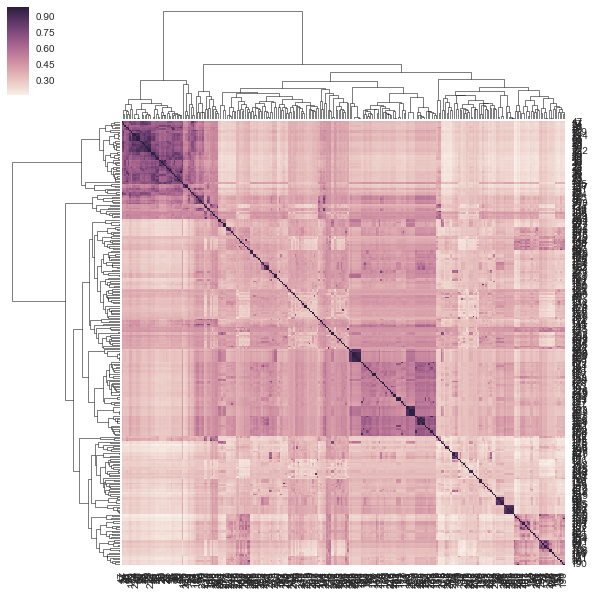

In [6]:
my_clustermap = sns.clustermap(my_matrix)

Nonetheless the graph shows that the first ~twenty-ish compounds are fairly related.  We can retrieve just these molecules and draw their structures.

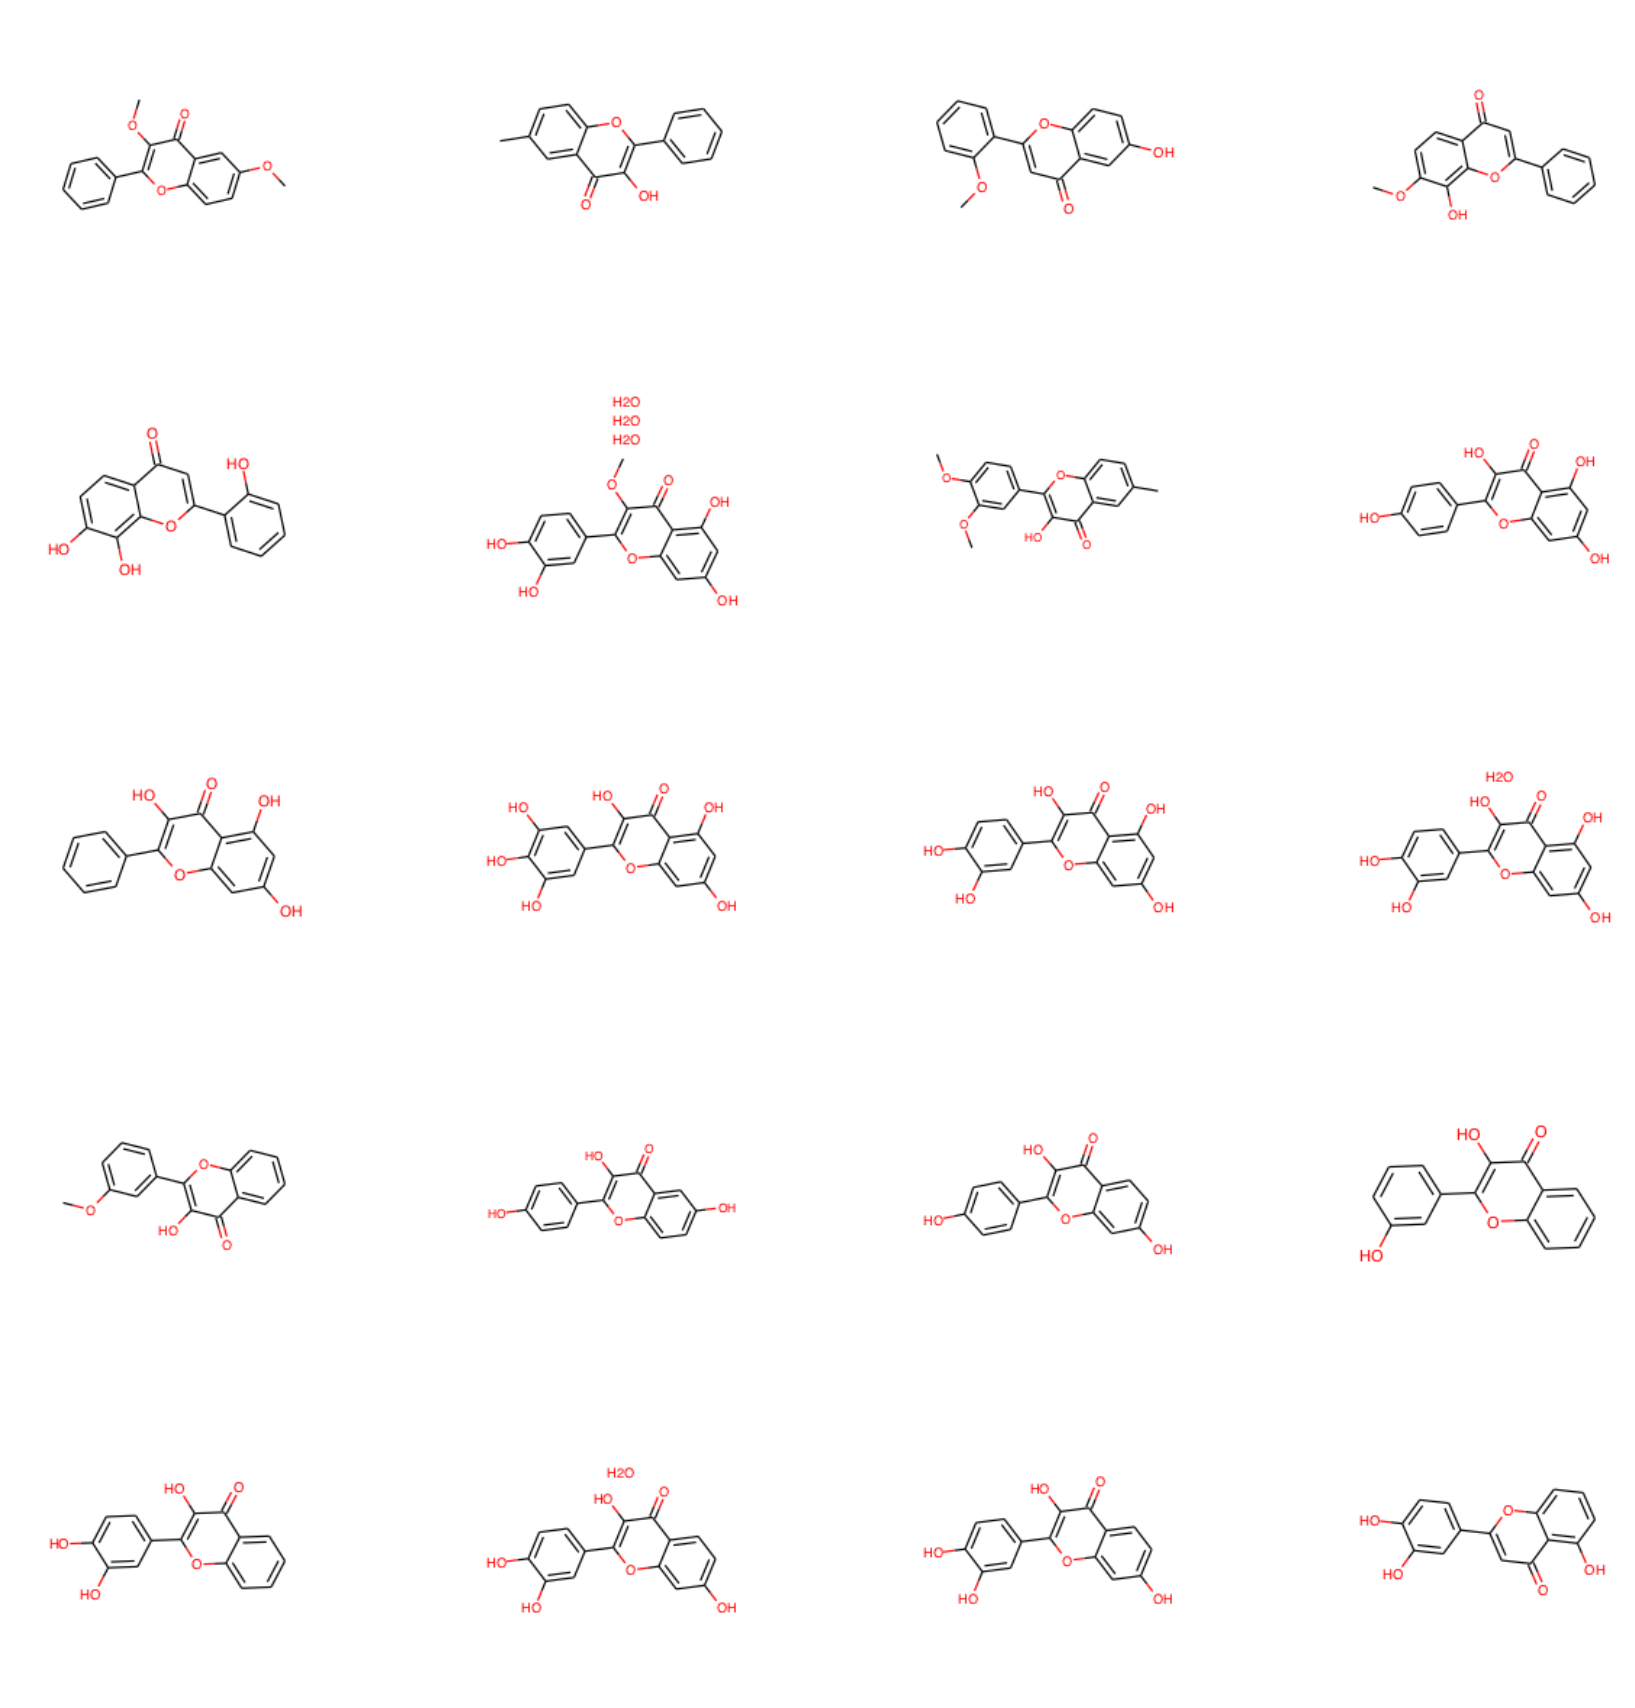

In [7]:
first_twenty_indices = my_clustermap.dendrogram_col.reordered_ind[0:20]

f, ax = plt.subplots(5, 4, figsize = (30, 30))

for counter, index in enumerate(first_twenty_indices):
    x, y = np.unravel_index(counter, dims=(5, 4))
    ax[x, y].imshow(Draw.MolToImage(mols[index], size=(200, 200), fitImage=True))
    ax[x, y].grid(False)
    ax[x, y].axis('off')